# Projeto de controladores na frequencia - parte 2

[Slides da aula](https://marofe.github.io/controle-digital/2024/aula7.html)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

from control.matlab import tf, c2d, feedback, pole
from control import forced_response
from scipy.signal import cont2discrete, tf2zpk, dlti, dstep
from control.matlab import *
from scipy import signal

### Questão 1
Nessa atividade, o objetivo é avaliar o efeito da saturação do sinal de controle. 
Para isso, considere um sistema de primeira ordem dado por

$$
M \frac{dy}{dt} = -y + u
$$

cuja função de transferência é

$$
G(s) = \frac{1}{Ms + 1}
$$

Suponha que o sinal de controle seja limitado na forma

$$
u_{min} \leq u \leq u_{max}
$$

Adote uma estrutura de controle do tipo PID na forma

$$
C(z) = Kp \left( 1 + \frac{Ts}{2T_I} \frac{z+1}{z-1} + T_D \frac{Ts}{z-1} z \right)
$$

Considere $T_s = 0.1s$. Faça sintonia para uma entrada em degrau unitário e comparações entre o comportamento do controlador PID nos seguintes casos:
1. Sem saturação e sem anti-windup;
2. Com saturação $0 \leq u \leq 5$ e sem anti-windup;
3. Com saturação $0 \leq u \leq 5$ e anti-windup.

Use o seguinte código Matlab como exemplo para simular esse sistema com um controlador PID:

```matlab
1 close all
2 clear all
3 clc
4 %%
5 s=tf('s');
6 M=2;
7 G=1/(M*s+1);
8 Ts=0.1;
9 Gd=c2d(G,Ts,'zoh');
10 zpk(Gd)
11 %%
12 Kp=10;
13 Td=0;
14 Ti=.2;
15 %%
16 T=20;
17 td=0:Ts:T; %vetor tempo discreto
18 dt=0.0001; %amostragem continuo
19 t=0:dt:T; %vetor de tempo continuo
20 y=zeros(size(t)); %tempo continuo
21 r=ones(size(t)); %tempo continuo
22 u=zeros(size(td)); %tempo discreto
23 u_out=zeros(size(td)); %tempo discreto
24 up=zeros(size(td)); %tempo discreto
25 ud=zeros(size(td)); %tempo discreto
26 ui=zeros(size(td)); %tempo discreto
27 erro=zeros(size(td)); %tempo discreto
28 erroI=zeros(size(td)); %tempo discreto
29 N=Ts/dt; %razao das amostragens continuo/discreto
30 kd=1; %contador do tempo discreto
31 u_max=5;
32 u_min=0;
33 for k=2:numel(t)
34 %% simula sistema em tempo continuo
35 y(k)=y(k-1)+1/M*(-y(k-1)+u_out(kd))*dt;
36
37 %% simula controle em tempo discreto
38 if (mod(k,N)==0 || k==2) && kd<numel(u)
39     kd=kd+1;
40     erro(kd)=r(k)-y(k);
41     %% sem anti-windup
42     erroI(kd)=erro(kd);
43     %% com anti-windup
44     % if u_out(kd-1)>=u_max || u_out(kd-1)<=u_min
45     %     erroI(kd)=0;
46     % else
47     %     erroI(kd)=erro(kd);
48     % end
49     %% Controle PID
50     up(kd)=Kp*erro(kd); %proporcional
51     ud(kd)=Kp*Td/Ts*(erro(kd)-erro(kd-1)); %derivativo (euler-backward)
52     ui(kd)=ui(kd-1)+Kp*Ts/Ti*erroI(kd); %integrativo (euler-backward)
53     u(kd)=up(kd)+ud(kd)+ui(kd);
54     %% sem saturacao
55     u_out(kd)=u(kd);
56     %% com saturacao
57     if u_out(kd)>u_max
58         u_out(kd)=u_max;
59     elseif u_out(kd)<u_min
60         u_out(kd)=u_min;
61     end
62
63 end
64
65 end
66 f = figure;
67 f.Position = [0 100 1200 500];
68 subplot(1,3,1)
69 plot(t,y,'LineWidth',2)
70 hold on
71 plot(t,r,'LineStyle','--','Color','black')
72 title('Sinal de saída')
73 legend('Saída','Referência')
74 subplot(1,3,2)
75 stairs(td,u,'LineWidth',2)
76 hold on
77 stairs(td,u_out,'LineWidth',2)
78 legend('u','u_{out}')
79 title('Sinal de controle')
80 subplot(1,3,3)
81 stairs(td,up,'LineWidth',1.5)
82 hold on
83 stairs(td,ud,'LineWidth',1.5)
84 stairs(td,ui,'LineWidth',1.5)
85 legend('Proporcional','Derivativo','Integral')
86 title('Termos de controle')
```

In [2]:
# Parâmetros
M = 2
Ts = 0.1
Kp = 10
Td = 0
Ti = 0.2
T = 20
dt = 0.0001
t = np.arange(0, T+dt, dt)   # vetor de tempo contínuo
td = np.arange(0, T+Ts, Ts)  # vetor de tempo discreto

# Sinal de referência
r = np.ones(len(t))          # referência no tempo contínuo

# Limites de controle
u_max = 5
u_min = 0

# Razão de amostragem contínua para discreta
N = int(Ts/dt)

# Dicionário para armazenar resultados de cada caso
results = {}

for case in [1, 2, 3]:
    # Inicializar variáveis
    y = np.zeros(len(t))         # saída no tempo contínuo
    u = np.zeros(len(td))        # sinal de controle no tempo discreto
    u_out = np.zeros(len(td))    # sinal de controle após saturação
    up = np.zeros(len(td))       # termo proporcional
    ud = np.zeros(len(td))       # termo derivativo
    ui = np.zeros(len(td))       # termo integral
    erro = np.zeros(len(td))     # erro
    erroI = np.zeros(len(td))    # erro para o termo integral (anti-windup)
    kd = 0                       # índice de tempo discreto

    # Loop de simulação
    for k in range(1, len(t)):
        # Simula o sistema no tempo contínuo
        y[k] = y[k-1] + (1/M)*(-y[k-1] + u_out[kd])*dt

        # Atualiza o controlador em intervalos discretos
        if (k % N == 0 or k == 1) and kd < len(u)-1:
            kd += 1
            erro[kd] = r[k] - y[k]

            # Tratamento anti-windup
            if case == 3:
                if u_out[kd-1] >= u_max or u_out[kd-1] <= u_min:
                    erroI[kd] = 0
                else:
                    erroI[kd] = erro[kd]
            else:
                erroI[kd] = erro[kd]

            # Controlador PID
            up[kd] = Kp * erro[kd]  # Termo proporcional
            ud[kd] = Kp * Td / Ts * (erro[kd] - erro[kd-1])  # Termo derivativo
            ui[kd] = ui[kd-1] + Kp * Ts / Ti * erroI[kd]     # Termo integral
            u[kd] = up[kd] + ud[kd] + ui[kd]                 # Controle total

            # Tratamento da saturação
            if case == 1:
                u_out[kd] = u[kd]  # Sem saturação
            else:
                u_out[kd] = u[kd]
                if u_out[kd] > u_max:
                    u_out[kd] = u_max
                elif u_out[kd] < u_min:
                    u_out[kd] = u_min

    # Armazena os resultados para o caso atual
    results[case] = {
        'y': y,
        'u': u,
        'u_out': u_out,
        'up': up,
        'ud': ud,
        'ui': ui,
        'erro': erro,
        'erroI': erroI
    }

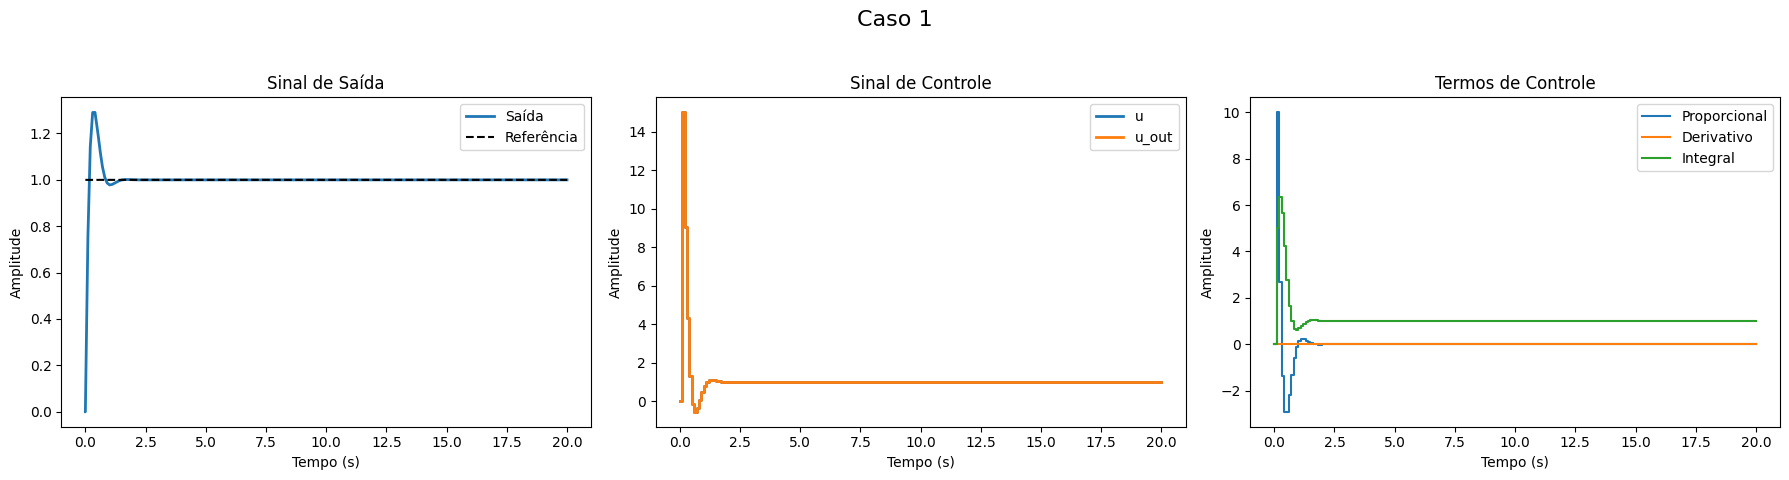

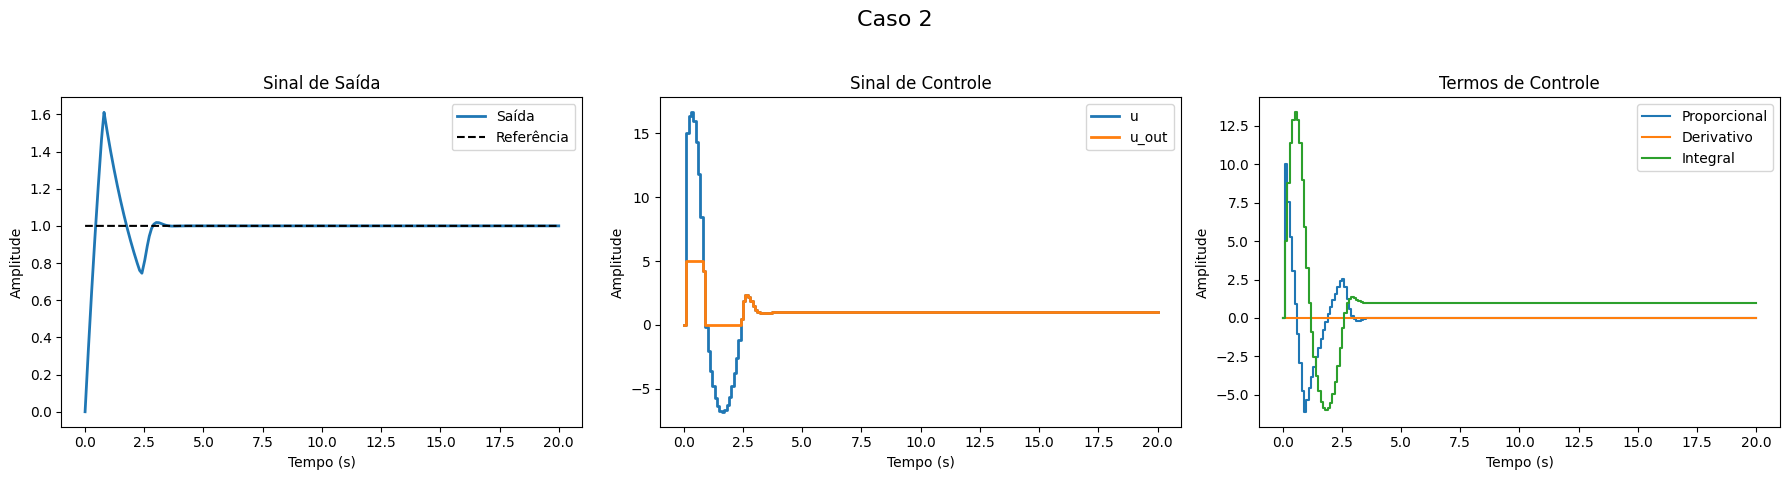

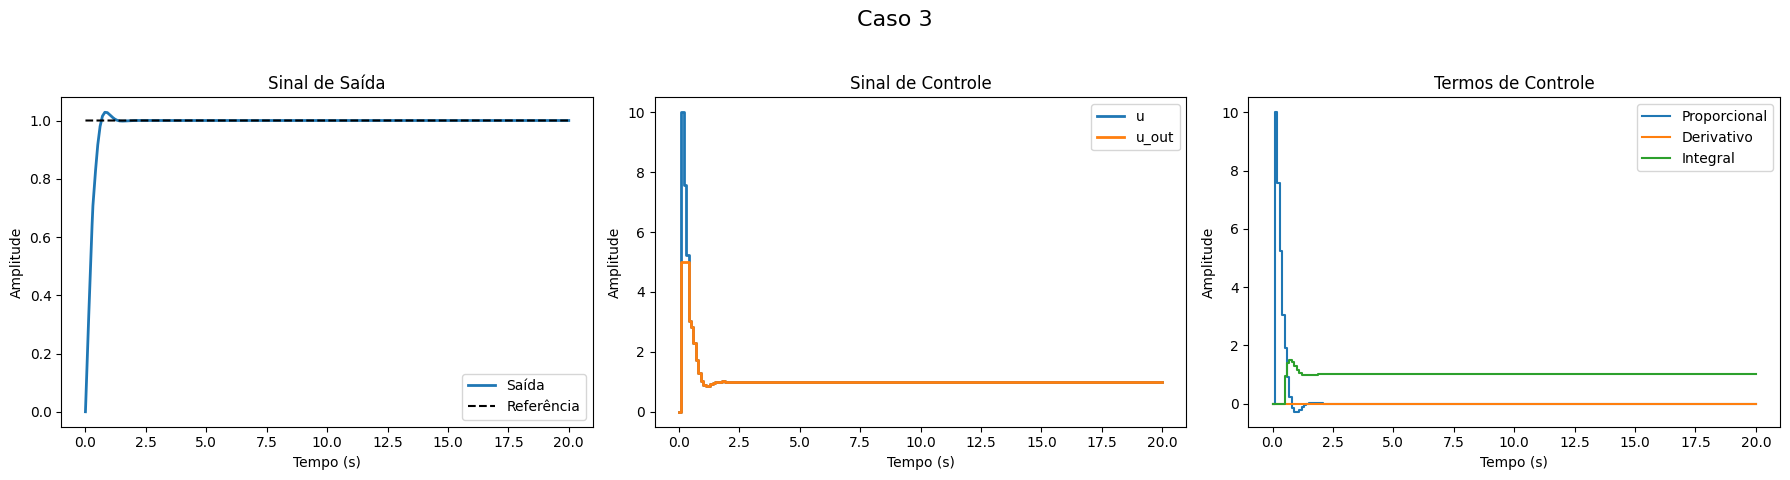

In [3]:
# Plotando os resultados para cada caso
for case in [1, 2, 3]:
    y = results[case]['y']
    u = results[case]['u']
    u_out = results[case]['u_out']
    up = results[case]['up']
    ud = results[case]['ud']
    ui = results[case]['ui']

    # Criar figura com subplots
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f'Caso {case}', fontsize=16)

    # Plotar sinal de saída e referência
    axs[0].plot(t, y, linewidth=2)
    axs[0].plot(t, r, linestyle='--', color='black')
    axs[0].set_title('Sinal de Saída')
    axs[0].legend(['Saída', 'Referência'])
    axs[0].set_xlabel('Tempo (s)')
    axs[0].set_ylabel('Amplitude')

    # Plotar sinais de controle
    axs[1].step(td, u, where='post', linewidth=2)
    axs[1].step(td, u_out, where='post', linewidth=2)
    axs[1].set_title('Sinal de Controle')
    axs[1].legend(['u', 'u_out'])
    axs[1].set_xlabel('Tempo (s)')
    axs[1].set_ylabel('Amplitude')

    # Plotar termos PID
    axs[2].step(td, up, where='post', linewidth=1.5)
    axs[2].step(td, ud, where='post', linewidth=1.5)
    axs[2].step(td, ui, where='post', linewidth=1.5)
    axs[2].set_title('Termos de Controle')
    axs[2].legend(['Proporcional', 'Derivativo', 'Integral'])
    axs[2].set_xlabel('Tempo (s)')
    axs[2].set_ylabel('Amplitude')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

### Questão 2
Nessa atividade o objetivo é projetar um controlador PID através do método do Lugar Geométrico das Raízes.

Para isso, considere a seguinte função de transferência como exemplo:

$$
G(s) = \frac{2}{(s + 2)(s + 3)}
$$

Deseja-se que o controle garanta um erro nulo para entrada em degrau e polos dominantes em malha-fechada com $\xi = 0.7$ e $\omega_n = 2.5 \, \text{rad/s}$ com tempo de amostragem $T_s = 0.3s$.

Assim, no plano-s, os polos dominantes que atendem aos critérios de desempenho são:

$$
s_{1,2} = -\xi\omega_n \pm \omega_n\sqrt{1 - \xi^2} = -1.75 \pm j1.7854
$$

Logo, no plano-z, os polos dominantes são:

$$
z_{1,2} = e^{s_{1,2}T_s} = 0.5824 \pm j0.2787
$$

O equivalente discreto da planta, usando o método de discretização degrau-invariante, é:

$$
G(z) = Z\left\{ \frac{1 - e^{-sT_s}}{s} G(s) \right\} = \frac{0.055568(z + 0.6061)}{(z - 0.5488)(z - 0.4066)}
$$

Adotando uma estrutura de controle do tipo PID, tem-se:

$$
C(z) = K_p \left(1 + \frac{T_s}{2T_I} \frac{z + 1}{z - 1} + \frac{T_D}{T_s} \frac{z - 1}{z} \right)
$$

Foi adotado o método de Tustin para o integrador e o método Euler-Backward para o derivador. De forma equivalente, a função de transferência do PID pode ser colocada na forma:

$$
C(z) = K \frac{(z - c_1)(z - c_2)}{z(z - 1)}
$$

em que $c_1$ e $c_2$ são os zeros do controlador PID e $K$ é o ganho total do controlador.

Uma vez obtidos os valores de $c_1$ e $c_2$, juntamente com o ganho $K$, os parâmetros do controlador PID na forma usual são dados por:

$$
K_p = \frac{K}{2} (c_1 + c_2 - 3c_1c_2 + 1)
$$

$$
T_I = \frac{T_s}{2} \frac{1 + c_1 + c_2 - 3c_1c_2}{1 + c_1c_2 - c_1 - c_2}
$$

$$
T_D = 2T_s \frac{c_1c_2}{c_1 + c_2 - 3c_1c_2 + 1}
$$

A sintonia do controlador PID pode ser realizada através da escolha da posição dos zeros do controlador e do ganho $K$. Assim, o PID pode ser sintonizado de forma analítica através do método do Lugar Geométrico das Raízes (LGR).

Por simplicidade, pode-se adotar um dos zeros do controlador PID de forma a cancelar um polo estável da planta. Escolhendo $c_1 = 0.5488$, falta encontrar os valores de $c_2$ e do ganho $K$.

Note que a função de transferência do ramo direto é:

$$
C(z)G(z) = K \frac{(z - c_2)}{z(z - 1)} \frac{0.055568(z + 0.6061)}{(z - 0.4066)}
$$

Para obter o valor de $c_2$, aplica-se a condição de fase do LGR:

$$
\angle C(z)G(z) = \angle (z_1 - c_2) + \angle (z_1 + 0.6061) - \angle (z_1 - 0) - \angle (z_1 - 1) - \angle (z_1 - 0.4066) = 180°
$$

Isolando $c_2$, resulta em:

$$
c_2 = 0.2995
$$

Por fim, para encontrar o ganho $K$, aplica-se a condição de módulo do LGR:

$$
|C(z)G(z)| = K \frac{(z - 0.2995)}{z(z - 1)} \frac{0.055568(z + 0.6061)}{(z - 0.4066)} = 1
$$

Isolando $K$, resulta em:

$$
K = 4.6116
$$

Portanto, o controlador PID projetado é:

$$
C(z) = 4.6116 \frac{(z - 0.5488)(z - 0.2995)}{z(z - 1)}
$$

e os ganhos do PID usual são:

$$
K_p = 3.1248
$$

$$
T_i = 0.6431
$$

$$
T_d = 0.0728
$$

### Seguindo a mesma lógica, projete um controlador PID para:

$$
G(s) = \frac{s + 2}{(s + 4)(s + 1)}
$$

com $T_s = 0.2s$ que garanta $\xi = 0.65$ e $\omega_n = 3 \, \text{rad/s}$.


```matlab
1 close all
2 clear all
3 clc
4 %%
5 s=tf('s');
6 G=2/((s+2)*(s+3));
7 Ts=0.3;
8 Gd=c2d(G,Ts,'zoh');
9 zpk(Gd)
10 xi=0.7;
11 wn=2.5;
12 s1=-xi*wn+1j*wn*sqrt(1-xi^2);
13 z1=exp(s1*Ts);
14 c1=0.5488;
15 %% condicao de fase
16 P=angle(z1+0.6061)-angle(z1)-angle(z1-1)-angle(z1-0.4066);
17 %angle(z1-c2)=pi-P;
18 c2=real(z1)-imag(z1)/tan(pi-P);
19 %% condicao de modulo
20 z=tf('z',Ts);
21 Ctemp=(z-c1)*(z-c2)/(z*(z-1));
22 K=1/abs(evalfr(Ctemp*Gd,z1));
23 %%
24 Cd=K*Ctemp;
25 Gf=Cd*Gd/(1+Cd*Gd);
26 p=pole(Gf);
27 figure;
28 plot(real(p),imag(p),'xr','LineWidth',2);
29 hold on;
30 zgrid(xi,wn,Ts);
31 axis equal;
32 %%
33 Kp=K/2*(c1+c2-3*c1*c2+1);
34 Ti=Ts/2*(1+c1+c2-3*c1*c2)/(1+c1*c2-c1-c2);
35 Td=2*Ts*c1*c2/(c1+c2-3*c1*c2+1);
36 %%
37 figure;
38 step(Gf);
```

In [4]:
# Define a função de transferência em tempo contínuo G(s) = (s + 2)/((s + 4)(s + 1))
num_s = [1, 2]  # Coeficientes do numerador
den_s = np.convolve([1, 4], [1, 1])  # Coeficientes do denominador
G_s = signal.TransferFunction(num_s, den_s)

# Tempo de amostragem
Ts = 0.2

# Discretiza G(s) para G(z) usando a técnica de retenção de ordem zero (ZOH)
G_z = G_s.to_discrete(Ts, method='zoh')

# Extrair os coeficientes do numerador e denominador de G(z)
num_z = G_z.num  # Numerador
den_z = G_z.den  # Denominador

# Encontrar os zeros e polos de G(z)
zeros_Gz = np.roots(num_z)
poles_Gz = np.roots(den_z)

# Razão de amortecimento desejada e frequência natural
xi = 0.65
wn = 3

# Calcular os polos desejados no plano s
s1 = -xi * wn + 1j * wn * np.sqrt(1 - xi**2)

# Mapear o polo desejado para o plano z
z1 = np.exp(s1 * Ts)

# Escolher c1 para cancelar um dos polos de G(z)
c1 = poles_Gz[0].real  # Cancelar o primeiro polo (assumindo que seja real)

# Zero e polo restantes de G(z)
zero_Gz = zeros_Gz[0]
pole_Gz = poles_Gz[1]

# Calcular as contribuições de ângulo para a condição de ângulo
P = (np.angle(z1 - zero_Gz) - np.angle(z1 - 0) - np.angle(z1 - 1) - np.angle(z1 - pole_Gz))

# Resolver para c2 usando a condição de ângulo
tan_P = np.tan(np.pi - P)
c2 = z1.real - z1.imag / tan_P

# Calcular G(z1)
G_z1_num = np.polyval(num_z, z1)
G_z1_den = np.polyval(den_z, z1)
G_z1 = G_z1_num / G_z1_den

# Calcular L(z1) sem o ganho K
L_z1 = (z1 - c2) * G_z1 / (z1 * (z1 - 1))

# Resolver K usando a condição de módulo
K = 1 / np.abs(L_z1)

# Calcular os parâmetros do PID
Kp = K / 2 * (c1 + c2 - 3 * c1 * c2 + 1)
Ti = Ts / 2 * (1 + c1 + c2 - 3 * c1 * c2) / (1 + c1 * c2 - c1 - c2)
Td = 2 * Ts * c1 * c2 / (c1 + c2 - 3 * c1 * c2 + 1)

# Exibir os parâmetros do PID
print(f"Parâmetros do PID calculados:\nKp = {Kp:.4f}\nTi = {Ti:.4f}\nTd = {Td:.4f}")

# Definir o controlador PID C(z)
C_num = K * np.array([1, -(c1 + c2), c1 * c2])  # Coeficientes do numerador
C_den = np.array([1, -1, 0])  # Coeficientes do denominador (z(z - 1))

# Função de transferência em malha aberta L(z) = C(z) * G(z)
L_num = np.convolve(C_num, num_z)
L_den = np.convolve(C_den, den_z)

# Função de transferência em malha fechada Gf(z) = L(z) / (1 + L(z))
Gf_num = L_num.copy()
Gf_den = np.polyadd(L_num, L_den)

# Criar função de transferência em tempo discreto para o sistema em malha fechada
Gf = signal.dlti(Gf_num, Gf_den, dt=Ts)

# Calcular os polos do sistema em malha fechada
closed_loop_poles = np.roots(Gf_den)

Parâmetros do PID calculados:
Kp = 0.6787
Ti = 2.1097
Td = 0.4737


/home/gian/.local/lib/python3.8/site-packages/scipy/signal/_filter_design.py:1746: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  warnings.warn("Badly conditioned filter coefficients (numerator): the "


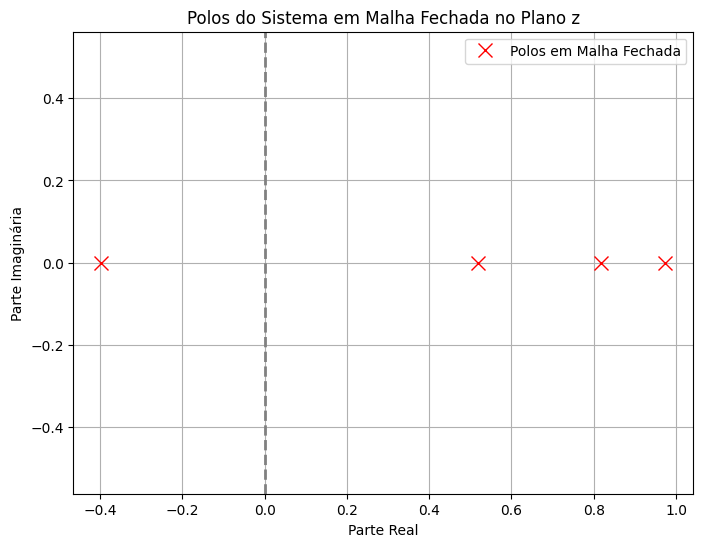

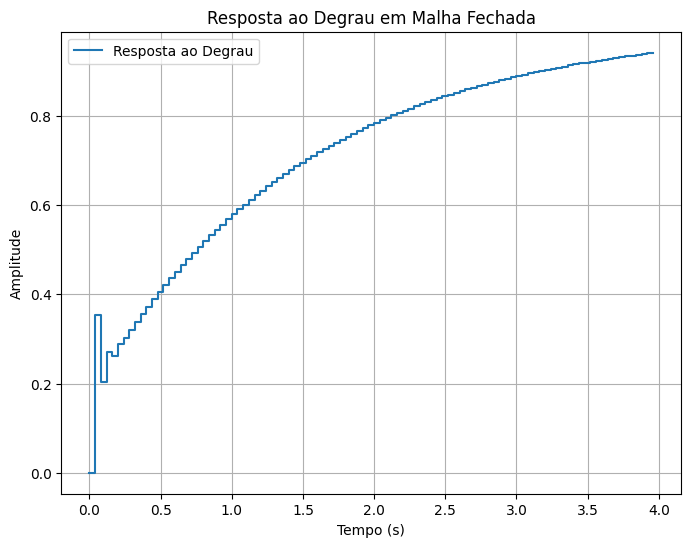

In [5]:
# Plotar os polos do sistema em malha fechada com uma linha vertical em x=0
plt.figure(figsize=(8, 6))
plt.plot(np.real(closed_loop_poles), np.imag(closed_loop_poles), 'rx', markersize=10, label='Polos em Malha Fechada')
plt.axvline(x=0, color='gray', linestyle='--', linewidth=2)
plt.title('Polos do Sistema em Malha Fechada no Plano z')
plt.xlabel('Parte Real')
plt.ylabel('Parte Imaginária')
plt.grid(True)
plt.legend()
plt.axis('equal')
plt.show()

# Plotar a resposta ao degrau do sistema em malha fechada
t_out, y_out = signal.dstep(Gf)
t_out = t_out * Ts  # Ajustar o vetor de tempo para o tempo real
y_out = np.squeeze(y_out)

plt.figure(figsize=(8, 6))
plt.step(t_out, y_out, where='post', label='Resposta ao Degrau')
plt.title('Resposta ao Degrau em Malha Fechada')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.show()

### Questão 3
Nessa atividade, o objetivo é usar os recursos computacionais do Matlab para projetar um controlador para um servo-motor.

Para isso, considere um servo-motor cuja dinâmica em tempo contínuo é descrita pela EDO:

$$
J \ddot{\theta} + \left( b + \frac{K_t K_b}{R} \right) \dot{\theta} = \frac{K_t K_a}{R} u
$$

em que:

- $J$ → inércia do rotor  
- $b$ → coeficiente de viscosidade  
- $R$ → resistência de armadura  
- $K_a$ → ganho do módulo de potência  
- $K_b$ → ganho de tensão induzida (eletromotriz)  
- $K_t$ → constante de torque do motor  
- $u$ → tensão de entrada  
- $\theta$ → posição angular do rotor  

Deseja-se projetar um controlador de tal forma que o sistema em malha fechada apresente sobressinal máximo de 16.3% ($M_p \leq 16.3\%$) e tempo de pico $t_p = 1s$.

Considere os parâmetros:

- $J = 5.3 \times 10^{-7}$
- $b = 7.7 \times 10^{-6}$
- $R = 2.6\Omega$
- $K_a = 1$
- $K_b = 7.67 \times 10^{-3}$
- $K_t = 7.67 \times 10^{-3}$

### Tarefas:

1. **Determine um tempo de amostragem** 10x menor que o tempo de oscilação amortecida ($T_d = \frac{1}{\omega_d}$) do sistema em malha fechada.

2. **Encontre os polos dominantes** de 2ª ordem que atendem os critérios de desempenho no plano-z.

3. **Obtenha a função de transferência equivalente em tempo discreto** para esse servo-motor considerando a presença de um ZOH.

4. **Escolha uma estrutura de controlador**, ex: PD, PI, PID, Avanço/Atraso de fase. Justifique sua escolha.

5. **Faça a sintonia do controlador** escolhido no item anterior de forma a atender os critérios de desempenho. (Dica: use LGR)

6. **Valide o projeto do controlador** através de testes via simulação de diferentes níveis de entrada em degrau sequencial (Dica: use o comando `gensig` do Matlab).

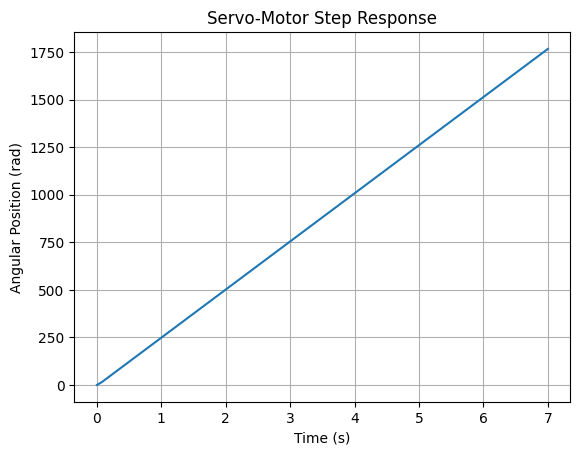

In [6]:
J = 5.3e-7
b = 7.7e-6
R = 2.6
K_a = 1
K_b = 7.67e-3
K_t = 7.67e-3

# Continuous transfer function
num = [K_t * K_a]
den = [J, (b + (K_t * K_b / R)), 0]
G_s = signal.TransferFunction(num, den)

# Damped frequency and sampling time
omega_d = np.pi  
T_d = 1 / omega_d  
T_s = T_d / 10  

G_z = signal.cont2discrete((num, den), T_s, method='zoh')

# Example PID controller parameters
Kp = 1.0
Ki = 1.0
Kd = 0.1
pid = signal.TransferFunction([Kd, Kp, Ki], [1, 0])

# Step response simulation
t, y = signal.step(G_s)

plt.plot(t, y)
plt.title('Servo-Motor Step Response')
plt.xlabel('Time (s)')
plt.ylabel('Angular Position (rad)')
plt.grid(True)
plt.show()

## Atividade 4
Nessa atividade o objetivo é fazer a sintonia de um controlador PID usando o algoritmo de otimização Particle Swarm (PSO).

Para isso, considere o sistema dado por:

$$
G(s) = \frac{1}{Ms + 1}
$$

Adotando uma estrutura de controle do tipo PID na forma:

$$
C(z) = K_p \left(1 + \frac{T_s}{2 T_I} \frac{z+1}{z-1} + \frac{T_D}{T_s} \frac{z-1}{z}\right)
$$

Busca-se encontrar os valores dos parâmetros $K_p$, $T_D$ e $T_I$ de forma que o controle PID atenda os seguintes critérios de desempenho:

1. $M_p \leq 15\%$
2. $\min \int_0^T |e(\tau)| d\tau$

Para utilizar o algoritmo PSO, deve-se definir uma função custo $J$ que atenda os critérios de projeto.

O algoritmo PSO, de forma simplificada, consiste em criar um conjunto de soluções candidatas e então "rastrear" as melhores soluções até atingir convergência. Para cada iteração, atualizam-se as partículas da seguinte forma:

$$
p_{i+1} = p_i + v_i
$$

$$
v_{i+1} = \alpha v_i + \beta_1 r_1 (p_{i\_best} - p_i) + \beta_2 r_2 (g_{best} - p_i)
$$

em que $\alpha$, $\beta_1$, $\beta_2$ são ajustes do algoritmo PSO e $r_1 \sim U[0,1]$, $r_2 \sim U[0,1]$ são variáveis aleatórias uniformes que aumentam a variabilidade da busca por novas soluções.

$$
p_i = \begin{bmatrix} p_1 \\ p_2 \\ \vdots \\ p_n \end{bmatrix}, \quad v_i = \begin{bmatrix} v_1 \\ v_2 \\ \vdots \\ v_n \end{bmatrix}
$$

São os vetores de parâmetros e respectivas velocidades para cada partícula.

No caso de um controlador PID, o vetor de parâmetros é:

$$
p_i = \begin{bmatrix} K_p \\ T_D \\ T_I \end{bmatrix}
$$

Para cada parâmetro, é importante definir a faixa de valores a serem explorados:

$$
K_{p\_min} \leq K_p \leq K_{p\_max}
$$

$$
T_{D\_min} \leq T_D \leq T_{D\_max}
$$

$$
T_{I\_min} \leq T_I \leq T_{I\_max}
$$

Tente reproduzir o resultado abaixo e aplicar em algum exemplo já estudado de sintonia de controladores.

O código em Matlab a seguir implementa esse algoritmo PSO para a sintonia de um controlador PID.

```matlab
1 close all
2 clear all
3 clc
4 %%
5 Ts=0.2;
6 s=tf('s');
7 T=2;
8 G=1/((s+3)*(T*s+1));
9 Gd=c2d(G,Ts,'zoh');
10 Mp max=0.15;
11 ts max=10;
12 tp max=2;
13 td=0:Ts:30;
14 function cost=J(p,Gd,Ts,Mp max,ts max,tp max,td)
15 Kp=p(1);
16 Td=p(2);
17 Ti=p(3);
18 z=tf('z',Ts);
19 Cd=Kp*(1+Ts/(2*Ti)*(z+1)/(z−1)+Td/Ts*(z−1)/z);
20 Gf=Cd*Gd/(1+Cd*Gd);
21 poles=pole(Gf);
22 if max(abs(poles))≤1
23 info=stepinfo(Gf);
24 ts=info.SettlingTime;
25 tp=info.PeakTime;
26 Mp=info.Overshoot;
27 y=step(Gd,td);
28
29 err=1−y;
30 c1=10;
31 c2=100;
32
33 if Mp/100>Mp max
34 cost=inf;
35 else
36 cost=c1*(Mp max−Mp/100)ˆ2+c2*sum(abs(err));
37 end
38 else
39 cost = inf;
40 end
41 end
42 %%
43 Kp min=0;
44 Kp max=15;
45 Td min=1;
46 Td max=2;
47 Ti min=0;
48 Ti max=2;
49 %%
50 N=30;
51 p(1,:)=Kp min+(Kp max−Kp min)*rand(1,N); %particulas (Kp)
52 p(2,:)=Td min+(Td max−Td min)*rand(1,N); %particulas (Td)
53 p(3,:)=Ti min+(Ti max−Ti min)*rand(1,N); %particulas (Ti)
54 p best=p; % aprendizado individual
55 v=2*randn(3,N); %velocidades
56
57 %parametros do PSO
58 alpha=0.5; %inercia
59 beta1=0.1; %aprendizado individual
60 beta2=0.3; %aprendizado do grupo
61 iter=50;
62 c best=zeros(iter,1);
63
64 f = figure;
65 f.Position = [0 100 1200 500];
66 for j=1:iter
67 %avalia desempenho de todas as particulas
68 c=zeros(N,1);
69 for i=1:N
70 c(i)=J(p(:,i),Gd,Ts,Mp max,ts max,tp max,td);
71 if c(i)< J(p best(:,i),Gd,Ts,Mp max,ts max,tp max,td)
72 p best(:,i)=p(:,i);
73 end
74 end
75 [c best(j),best]=min(c);
76 p global=p(:,best); %melhor solucao global
77 %%
78 subplot(1,3,1)
79 plot(c best(1:j),'o−','LineWidth',1.5)
80 xlabel('iter')
81 ylabel('J(p)')
82 grid on
83 title(['iter' num2str(j)])
84 subplot(1,3,2)
85 hold off
86 plot3(p(1,:),p(2,:),p(3,:),'or','LineWidth',3);
87 hold on
88 quiver3(p(1,:),p(2,:),p(3,:),v(1,:),v(2,:),v(3,:),'g','LineWidth',1);
89 xlabel('Kp')
90 ylabel('Td')
91 zlabel('Ti')
92 xlim([Kp min Kp max])
93 ylim([Td min Td max])
94 zlim([Ti min Td max])
95 grid on
96 subplot(1,3,3)
97 hold off
98 z=tf('z',Ts);
99 Kp=p global(1);
100 Td=p global(2);
101 Ti=p global(3);
102 Cd=Kp*(1+Ts/(2*Ti)*(z+1)/(z−1)+Td/Ts*(z−1)/z);
103 Gf=Cd*Gd/(1+Cd*Gd);
104 y=step(Gf,td);
105 stairs(td,y,'LineWidth',1.5)
106 hold on
107 line([0 max(td)], [1 1]+Mp max,'linestyle','−−','color','black')
108 line([ts max ts max], [0 1+Mp max],'linestyle','−−','color','black')
109 drawnow
110 %%
111 for i=1:N
112 p(:,i)=p(:,i)+v(:,i);
113 r1=rand;
114 r2=rand;
115 v(:,i)=alpha*v(:,i)+beta1*r1*(p best(:,i)−p(:,i))+beta2*r2*(p global−p(:,i));
116 %% garante intervalos
117 if p(1,i)<Kp min
118 p(1,i)=Kp min;
119 end
120 if p(1,i)>Kp max
121 p(1,i)=Kp max;
122 end
123 if p(2,i)<Td min
124 p(2,i)=Td min;
125 end
126 if p(2,i)>Td max
127 p(2,i)=Td max;
128 end
129 if p(3,i)<Ti min
130 p(3,i)=Ti min;
131 end
132 if p(3,i)>Ti max
133 p(3,i)=Ti max;
134 end
135 end
136
137 end
```

In [7]:
def compute_performance(t, y):
    y_final = y[-1]
    y_peak = np.max(y)
    Mp = ((y_peak - y_final) / y_final) * 100  

    idx_peak = np.argmax(y)
    tp = t[idx_peak]

    # Settling time: time when y remains within 2% of y_final
    tolerance = 0.02 * y_final
    idx_settling = np.where(np.abs(y - y_final) > tolerance)[0]
    if len(idx_settling) > 0:
        ts = t[idx_settling[-1]]
    else:
        ts = t[-1]
    return Mp, tp, ts

In [8]:
def J(p, Gd, Ts, Mp_max, ts_max, tp_max, td):
    Kp = p[0]
    Td = p[1]
    Ti = p[2]
    
    # Avoid division by zero
    if Ti == 0:
        return np.inf

    z_num = [1, 0]
    z_den = [1]
    z = tf(z_num, z_den, Ts)

    # PID controller in discrete time
    Cd = Kp * (1 + (Ts / (2 * Ti)) * (z + 1) / (z - 1) + (Td / Ts) * (z - 1) / z)

    Gf = feedback(Cd * Gd, 1)

    # Check system stability
    poles = pole(Gf)
    if np.max(np.abs(poles)) <= 1:
        t_out, y_out = forced_response(Gf, td, np.ones_like(td))
        
        # Compute performance metrics
        Mp, tp, ts = compute_performance(t_out, y_out)
        
        # Compute error
        err = 1 - y_out

        c1 = 10
        c2 = 100

        if Mp / 100 > Mp_max:
            cost = np.inf
        else:
            cost = c1 * (Mp_max - Mp / 100) ** 2 + c2 * np.sum(np.abs(err))
    else:
        cost = np.inf
    return cost

In [9]:
def PSO_PID_tuning():
    # System parameters
    Ts = 0.2  # Sampling time
    M = 30     # adjust as needed
    s = tf([1, 0], [1])

    G = 1 / (M * s + 1)
    Gd = c2d(G, Ts, method='zoh') 

    # Performance criteria
    Mp_max = 0.15  # Maximum overshoot (15%)
    ts_max = 10    # Maximum settling time
    tp_max = 2     # Maximum peak time
    td = np.arange(0, 30 + Ts, Ts) 

    # Parameter bounds
    Kp_min = 0
    Kp_max = 100  # Adjusted for this system
    Td_min = 0.0  # Adjusted lower bound
    Td_max = 10   # Adjusted upper bound
    Ti_min = 0.01  # Avoid division by zero
    Ti_max = 10    # Adjusted upper bound

    # PSO parameters
    N = 30       # Number of particles
    iter_max = 50  # Number of iterations
    alpha = 0.5    # Inertia coefficient
    beta1 = 0.1    # Cognitive coefficient
    beta2 = 0.3    # Social coefficient

    # Initialize particles and velocities
    p = np.zeros((3, N))
    p[0, :] = Kp_min + (Kp_max - Kp_min) * np.random.rand(N)  # Kp particles
    p[1, :] = Td_min + (Td_max - Td_min) * np.random.rand(N)  # Td particles
    p[2, :] = Ti_min + (Ti_max - Ti_min) * np.random.rand(N)  # Ti particles
    p_best = np.copy(p)  # Individual best positions
    v = 2 * np.random.randn(3, N)  # Velocities

    c_best = np.zeros(iter_max)
    g_best = None  # Global best position

    # PSO main loop
    for j in range(iter_max):
        c = np.zeros(N)
        for i in range(N):
            c[i] = J(p[:, i], Gd, Ts, Mp_max, ts_max, tp_max, td)
            if c[i] < J(p_best[:, i], Gd, Ts, Mp_max, ts_max, tp_max, td):
                p_best[:, i] = p[:, i]

        # Update global best
        c_best[j] = np.min(c)
        best_idx = np.argmin(c)
        p_global = p[:, best_idx]

        # Update velocities and positions
        for i in range(N):
            r1 = random.random()
            r2 = random.random()
            v[:, i] = alpha * v[:, i] + beta1 * r1 * (p_best[:, i] - p[:, i]) + beta2 * r2 * (p_global - p[:, i])
            p[:, i] = p[:, i] + v[:, i]

            # Enforce bounds
            p[0, i] = np.clip(p[0, i], Kp_min, Kp_max)
            p[1, i] = np.clip(p[1, i], Td_min, Td_max)
            p[2, i] = np.clip(p[2, i], Ti_min, Ti_max)

        print(f"Iteration {j+1}/{iter_max}, Best Cost: {c_best[j]}")

    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(c_best, 'o-', linewidth=1.5)
    plt.xlabel('Iteration')
    plt.ylabel('Cost J(p)')
    plt.title('Cost over Iterations')
    plt.grid(True)

    ax = plt.subplot(1, 3, 2, projection='3d')
    ax.scatter(p[0, :], p[1, :], p[2, :], color='r', label='Particles')
    ax.set_xlabel('Kp')
    ax.set_ylabel('Td')
    ax.set_zlabel('Ti')
    ax.set_xlim([Kp_min, Kp_max])
    ax.set_ylim([Td_min, Td_max])
    ax.set_zlim([Ti_min, Ti_max])
    ax.set_title('Particle Positions')
    ax.grid(True)

    # Plot step response of best controller
    plt.subplot(1, 3, 3)
    Kp_best = p_global[0]
    Td_best = p_global[1]
    Ti_best = p_global[2]
    z_num = [1, 0]
    z_den = [1]
    z = tf(z_num, z_den, Ts)
    Cd_best = Kp_best * (1 + (Ts / (2 * Ti_best)) * (z + 1) / (z - 1) + (Td_best / Ts) * (z - 1) / z)
    Gf_best = feedback(Cd_best * Gd, 1)
    t_out, y_out = forced_response(Gf_best, td, np.ones_like(td))
    plt.step(t_out, y_out, linewidth=1.5)
    plt.xlabel('Time (s)')
    plt.ylabel('Response')
    plt.title('Best Controller Step Response')
    plt.grid(True)

    plt.axhline(1 + Mp_max, linestyle='--', color='black', label='Overshoot Limit')
    plt.axvline(ts_max, linestyle='--', color='black', label='Settling Time Limit')
    plt.legend()

    plt.tight_layout()
    plt.show()

Iteration 1/50, Best Cost: 255.36923317920295
Iteration 2/50, Best Cost: 260.4185199054816
Iteration 3/50, Best Cost: 258.92241453683044
Iteration 4/50, Best Cost: 256.33105035461233
Iteration 5/50, Best Cost: 256.7944300324552
Iteration 6/50, Best Cost: 257.1475017033006
Iteration 7/50, Best Cost: 257.2907706692652
Iteration 8/50, Best Cost: 254.9926624400189
Iteration 9/50, Best Cost: 254.84834690642168
Iteration 10/50, Best Cost: 254.77560468465472
Iteration 11/50, Best Cost: 252.00310696208626
Iteration 12/50, Best Cost: 251.52013395529306
Iteration 13/50, Best Cost: 251.394974514766
Iteration 14/50, Best Cost: 250.78068126285285
Iteration 15/50, Best Cost: 250.7934512969568
Iteration 16/50, Best Cost: 250.77499878849417
Iteration 17/50, Best Cost: 250.66016172294258
Iteration 18/50, Best Cost: 250.74436506614717
Iteration 19/50, Best Cost: 250.73805780417402
Iteration 20/50, Best Cost: 250.64937525126604
Iteration 21/50, Best Cost: 250.4261808031576
Iteration 22/50, Best Cost: 250

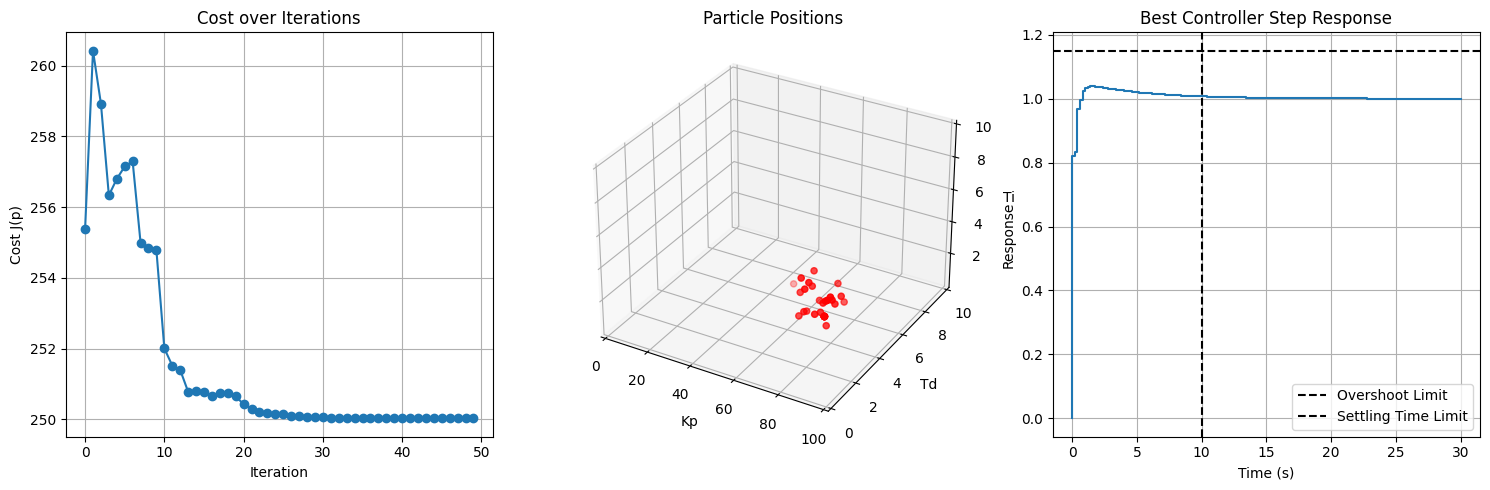

In [10]:
PSO_PID_tuning()